<a href="https://colab.research.google.com/github/ham952/ViT/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

### 1. Hyperparameters

In [22]:
BATCH_SIZE = 128
EPOCHS = 10 # Try increasing epochs to 30
LEARNING_RATE = 3e-4
PATCH_SIZE = 4  # P
NUM_CLASSES = 10  # CIFAR-10
IMAGE_SIZE = 32 # Transform the image and make the size go to 224
CHANNELS = 3
EMBED_DIM = 256 # or 512 # E
NUM_HEADS = 8 # INcrease the number heads
DEPTH = 6 # transformer blocks
MLP_DIM = 512
DROP_RATE = 0.1

### 2. Image transformations

In [23]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Normalize((0.5), (0.5))
])

### 3. Dataset

In [24]:
train_dataset = datasets.CIFAR10(root="data",
                                 train= True,
                                 download=True,
                                 transform=transform)

test_dataset = datasets.CIFAR10(root="data",
                                 train= False,
                                 download=True,
                                 transform=transform)

In [25]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

### 4. Data Loaders

In [26]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

In [27]:
# Let's check out what we've created
print(f"DataLoader: {train_loader, test_loader}")
print(f"Length of train_loader: {len(train_loader)} batches of {BATCH_SIZE}...")
print(f"Length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}...")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x79e5167b7a10>, <torch.utils.data.dataloader.DataLoader object at 0x79e514114710>)
Length of train_loader: 390 batches of 128...
Length of test_loader: 79 batches of 128...


## Transformer

### 1. Patch Embeddings

In [53]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                img_size,
                patch_size,
                in_channels,
                embed_dim):
      super().__init__()

      self.patch_size = patch_size
      self.proj = nn.Conv2d(in_channels= in_channels,
                            out_channels= embed_dim,
                            kernel_size=patch_size,
                            stride = patch_size)
      num_patches = (img_size // patch_size) ** 2
      self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True)
      self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim), requires_grad= True)

    def forward(self, x:torch.Tensor):
      B = x.size(0)
      x = self.proj(x) # (B, E, H/P, W/P)
      x = x.flatten(2).transpose(1, 2) # (B, N, E)
      cls_tokens = self.cls_token.expand(B, -1, -1)
      x = torch.cat([cls_tokens, x], dim=1)
      x = x + self.pos_embed
      return x


In [75]:
class PatchEmbedding(nn.Module):
  def __init__(self, img_size, patch_size,
                in_channels,
                embed_dim):
      super().__init__()
      self.patcher = nn.Sequential(
          # We use conv for doing the patching
          nn.Conv2d(
              in_channels=in_channels,
              out_channels=embed_dim,
              # if kernel_size = stride -> no overlap
              kernel_size=patch_size,
              stride=patch_size
          ),
          # Linear projection of Flattened Patches. We keep the batch and the channels (b,c,h,w)
          nn.Flatten(2))
      num_patches = (img_size // patch_size) ** 2
      self.cls_token = nn.Parameter(torch.randn(size=(1, 1, embed_dim)), requires_grad=True)
      self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
      self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
      # Create a copy of the cls token for each of the elements of the BATCH
      cls_token = self.cls_token.expand(x.shape[0], -1, -1)
      # Create the patches
      x = self.patcher(x).permute(0, 2, 1)
      # Unify the position with the patches
      x = torch.cat([cls_token, x], dim=1)
      # Patch + Position Embedding
      x = self.position_embeddings + x
      x = self.dropout(x)
      return x

In [88]:
class MLP(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features,
                             out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features,
                             out_features=in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [89]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

In [90]:

class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.norm(x)
        cls_token = x[:, 0]
        return self.head(cls_token)

# Training

In [91]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES, EMBED_DIM, DEPTH, NUM_HEADS,
    MLP_DIM, DROP_RATE).to(device)

In [92]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (patcher): Sequential(
      (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
      (1): Flatten(start_dim=2, end_dim=-1)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, o

In [93]:
criterion = nn.CrossEntropyLoss() # Measure how wrong our model is
optimizer = torch.optim.Adam(params=model.parameters(), # update our model's parameters to try and reduce the loss
                             lr=LEARNING_RATE)

In [94]:
def train(model, loader, optimizer, criterion):

    model.train()

    total_loss, correct = 0, 0

    for x, y in loader:
        # Moving (Sending) our data into the target device
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        # 1. Forward pass (model outputs raw logits)
        out = model(x)
        # 2. Calcualte loss (per batch)
        loss = criterion(out, y)
        # 3. Perform backpropgation
        loss.backward()
        # 4. Perforam Gradient Descent
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    # You have to scale the loss (Normlization step to make the loss general across all batches)
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [95]:
def evaluate(model, loader):
    model.eval() # Set the mode of the model into evlauation
    correct = 0
    with torch.inference_mode():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(dim=1) == y).sum().item()
    return correct / len(loader.dataset)

In [96]:
from tqdm.auto import tqdm

In [97]:
### Training
train_accuracies, test_accuracies = [], []

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_acc = evaluate(model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Epoch: {epoch+1}/{EPOCHS}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}%, Test acc: {test_acc:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10, Train loss: 1.7578, Train acc: 0.3626%, Test acc: 0.4608
Epoch: 2/10, Train loss: 1.4406, Train acc: 0.4806%, Test acc: 0.5120
Epoch: 3/10, Train loss: 1.3024, Train acc: 0.5296%, Test acc: 0.5587
Epoch: 4/10, Train loss: 1.2073, Train acc: 0.5634%, Test acc: 0.5717
Epoch: 5/10, Train loss: 1.1307, Train acc: 0.5923%, Test acc: 0.5948
Epoch: 6/10, Train loss: 1.0710, Train acc: 0.6140%, Test acc: 0.6091
Epoch: 7/10, Train loss: 1.0081, Train acc: 0.6359%, Test acc: 0.6150
Epoch: 8/10, Train loss: 0.9488, Train acc: 0.6589%, Test acc: 0.6262
Epoch: 9/10, Train loss: 0.9016, Train acc: 0.6746%, Test acc: 0.6268
Epoch: 10/10, Train loss: 0.8504, Train acc: 0.6927%, Test acc: 0.6389


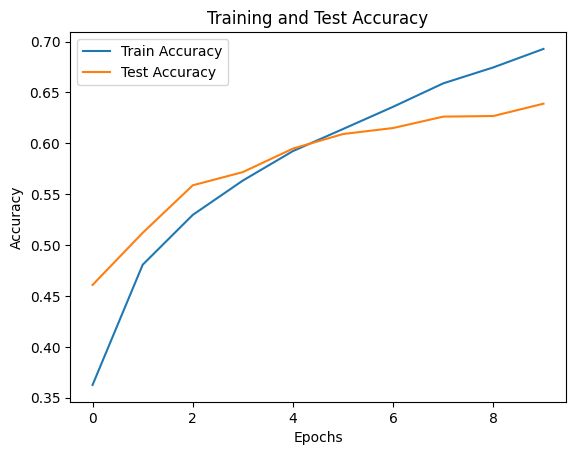

In [98]:
# Plot accuracy
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.show()

In [ ]:
test_dataset[0][0].unsqueeze(dim=0).shape

In [99]:
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5 # Unormalize our images to be able to plot them with matplotlib
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r"

            axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=color)
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

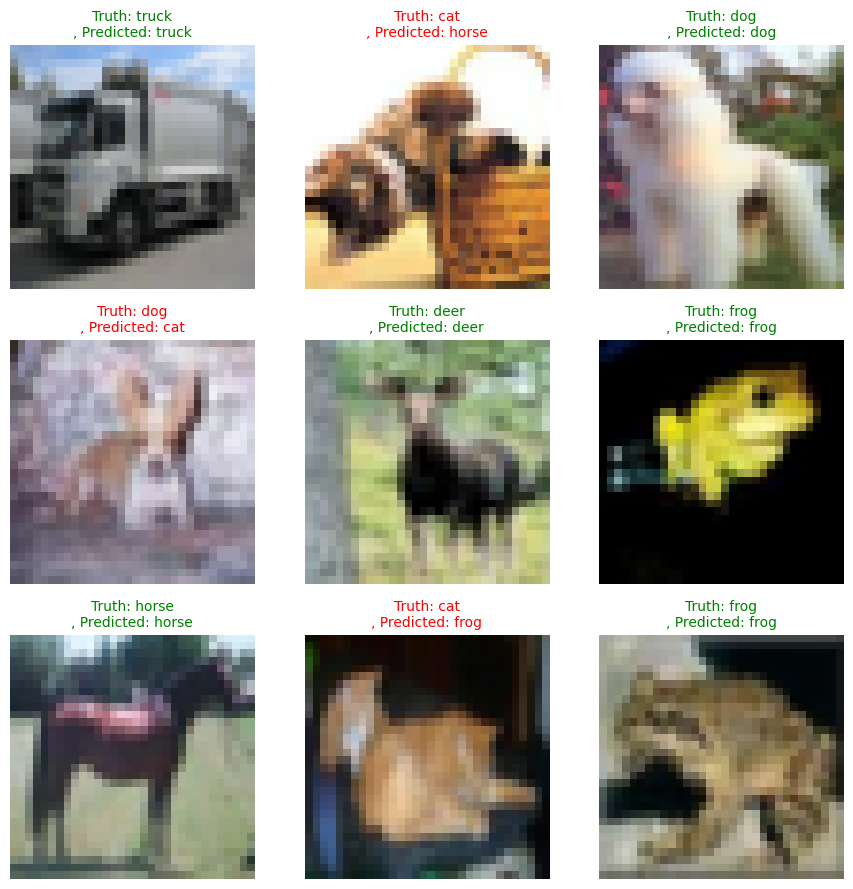

In [100]:
predict_and_plot_grid(model=model,
                      dataset=test_dataset,
                      classes=train_dataset.classes,
                      grid_size=3)